# Setup

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot, chi2

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

base_df = pd.read_csv("data_1.csv", index_col=0)

/tmp/ipykernel_4211/1034996539.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Univariate outlier detection according to the rule of thumb:
# Values that lie outside the interval [E(Salary)-3,5*σ, E(Salary)+3,5*σ] are considered outliers
mean_salary = base_df['salary'].mean()
std_salary = base_df['salary'].std()

lower_bound = mean_salary - 3.5 * std_salary
upper_bound = mean_salary + 3.5 * std_salary

print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")

outliers_uv = base_df[(base_df['salary'] < lower_bound) | (base_df['salary'] > upper_bound)]
outliers_uv.sort_values(by='salary')

Lower bound: -33673.691524622074
Upper bound: 268921.08149783587


,score,salary,happiness,Age
797,88,-164801.150081,1.0,48
372,77,-151112.222803,1.0,78
801,22,-92822.767823,1.0,78
484,56,-84455.351609,20.0,54
364,44,-69725.546360,20.0,71
51,36,-48194.031763,1.0,30
528,77,-46857.508922,1.0,23
773,52,-38788.531785,20.0,22
883,49,269075.046479,81.0,40
991,42,297158.567626,81.0,79


According to our domain knowledge about salary (non-negative, outliers for large values likely), we can find different outliers:

In [4]:
outliers_dk = base_df[(base_df['salary'] < 0)]
outliers_dk.sort_values(by='salary')

,score,salary,happiness,Age
797,88,-164801.150081,1.0,48
372,77,-151112.222803,1.0,78
801,22,-92822.767823,1.0,78
484,56,-84455.351609,20.0,54
364,44,-69725.546360,20.0,71
51,36,-48194.031763,1.0,30
528,77,-46857.508922,1.0,23
773,52,-38788.531785,20.0,22
348,59,-31883.990479,20.0,65
271,97,-20946.363596,1.0,38


# Multivariate Outliers?

Check for multivariate normality (QQ plot for Chi-Square distribution)

In [5]:
# check for multivariate normality
# df = degrees of freedom = 4 (4 features)
deg_f = len(base_df.columns)

# Calculate the mean
cm = base_df.mean()
# covariance matrix
S = base_df.cov()

# Complete Case analysis for now (otherwise squared distances are also Null)
missing_data = base_df[base_df.isna().any(axis=1)].copy()
data = base_df.dropna().copy()
# Calculate the squared distance row-wise
d = base_df.apply(lambda x: np.dot(np.dot(x - cm, np.linalg.inv(S)), (x - cm)), axis=1)

In [6]:
data['sorted_d'] = d
data = data.sort_values(by='sorted_d')

In [7]:
# Get the theoretical quantile value for each observed one
n = len(data)
data['qc']= [chi2.ppf((i - 0.5) / n, df=deg_f) for i in range(1, n + 1)]
data

,score,salary,happiness,Age,sorted_d,qc
789,42,104488.404942,40.0,46,0.174520,0.065847
269,58,129479.904514,61.0,47,0.185603,0.114984
724,48,135812.627625,61.0,51,0.263032,0.149290
492,39,116423.394349,41.0,51,0.268721,0.177468
912,47,134857.221461,61.0,47,0.306713,0.202050
...,...,...,...,...,...,...
801,22,-92822.767823,1.0,78,39.149399,14.966120
484,56,-84455.351609,20.0,54,42.213540,15.534673
120,7,335667.945179,100.0,45,48.299689,16.292207
372,77,-151112.222803,1.0,78,75.296426,17.435066


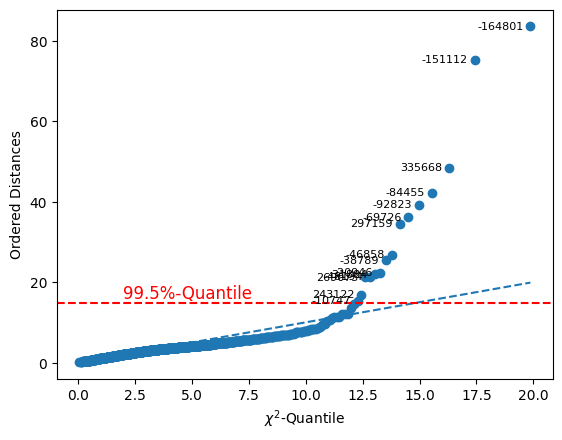

In [8]:
# Plot theoretical and empirical quantiles
quantile_995 = chi2.ppf(1 - 0.005, df=deg_f)
plt.scatter(data['qc'], data['sorted_d'])
plt.plot(data['qc'], data['qc'], linestyle='--', label='y = x (slope 1)')
plt.xlabel(r'$\chi^2$-Quantile')
plt.ylabel('Ordered Distances')
plt.axhline(y=quantile_995, color='red', linestyle='--')
plt.text(2, quantile_995, '99.5%-Quantile', color='red', fontsize=12, verticalalignment='bottom')

# Annotate the 15 largest distances with their respective salary
for i in range(15):
    plt.annotate(
        f'{data.iloc[-i-1]["salary"]:.0f}', 
        (data.iloc[-i-1]["qc"], data.iloc[-i-1]["sorted_d"]),
        xytext=(-5, -2),  # Offset the text to the left by 10 units
        textcoords='offset points',  # Interpret `xytext` as offset in points
        fontsize=8,  # Make the text smaller
        ha='right'  # Horizontally align the text to the right
    )

plt.show()

One could argue for a mutlivariate normal distribution. At least up to the theoretical quantiles of about 11.5 to 12. We can apply the multivariate parametric method now: Values above the 99.5% quantile (here about 14.86) are identified as outliers

In [9]:
quantile_995

14.860259000560243

In [10]:
# multivariate outliers with parametric method
mvp_outliers = data[(data['sorted_d'] > quantile_995)]
mvp_outliers.sort_values(by='sorted_d')

,score,salary,happiness,Age,sorted_d,qc
411,43,-10747.368463,20.0,72,15.393364,12.281466
425,22,243121.866867,81.0,67,16.861879,12.447502
883,49,269075.046479,81.0,40,21.139167,12.625980
51,36,-48194.031763,1.0,30,21.386150,12.818959
348,59,-31883.990479,20.0,65,21.937530,13.029059
271,97,-20946.363596,1.0,38,22.275688,13.259683
773,52,-38788.531785,20.0,22,25.402124,13.515368
528,77,-46857.508922,1.0,23,26.755315,13.802349
991,42,297158.567626,81.0,79,34.386228,14.129538
364,44,-69725.546360,20.0,71,36.070390,14.510312


Those oberservations depicted as outliers match to certain extinct the outliers depicted by the univariate parametric method and the ones depicted by our domain knowledge. Mainly multivariate outliers have been found where the observed value for salary would also be an univariate outlier.

In total it seems to be reasonable to remove outliers with a negative salary. Additionally one could argue to also remove those outliers with a positive value for salary, which are at the same time depcited as a multivariate outlier.

We go with our domain knowledge and remove all outliers with a negative salary, but keep the ones with a positive salary.

In [11]:
# Remove outliers with negative salary but keep NaNs
base_df_no_outliers = base_df[(base_df['salary'] >= 0) | (base_df['salary'].isna())]
base_df_no_outliers.to_csv("data_1_no_outliers.csv")

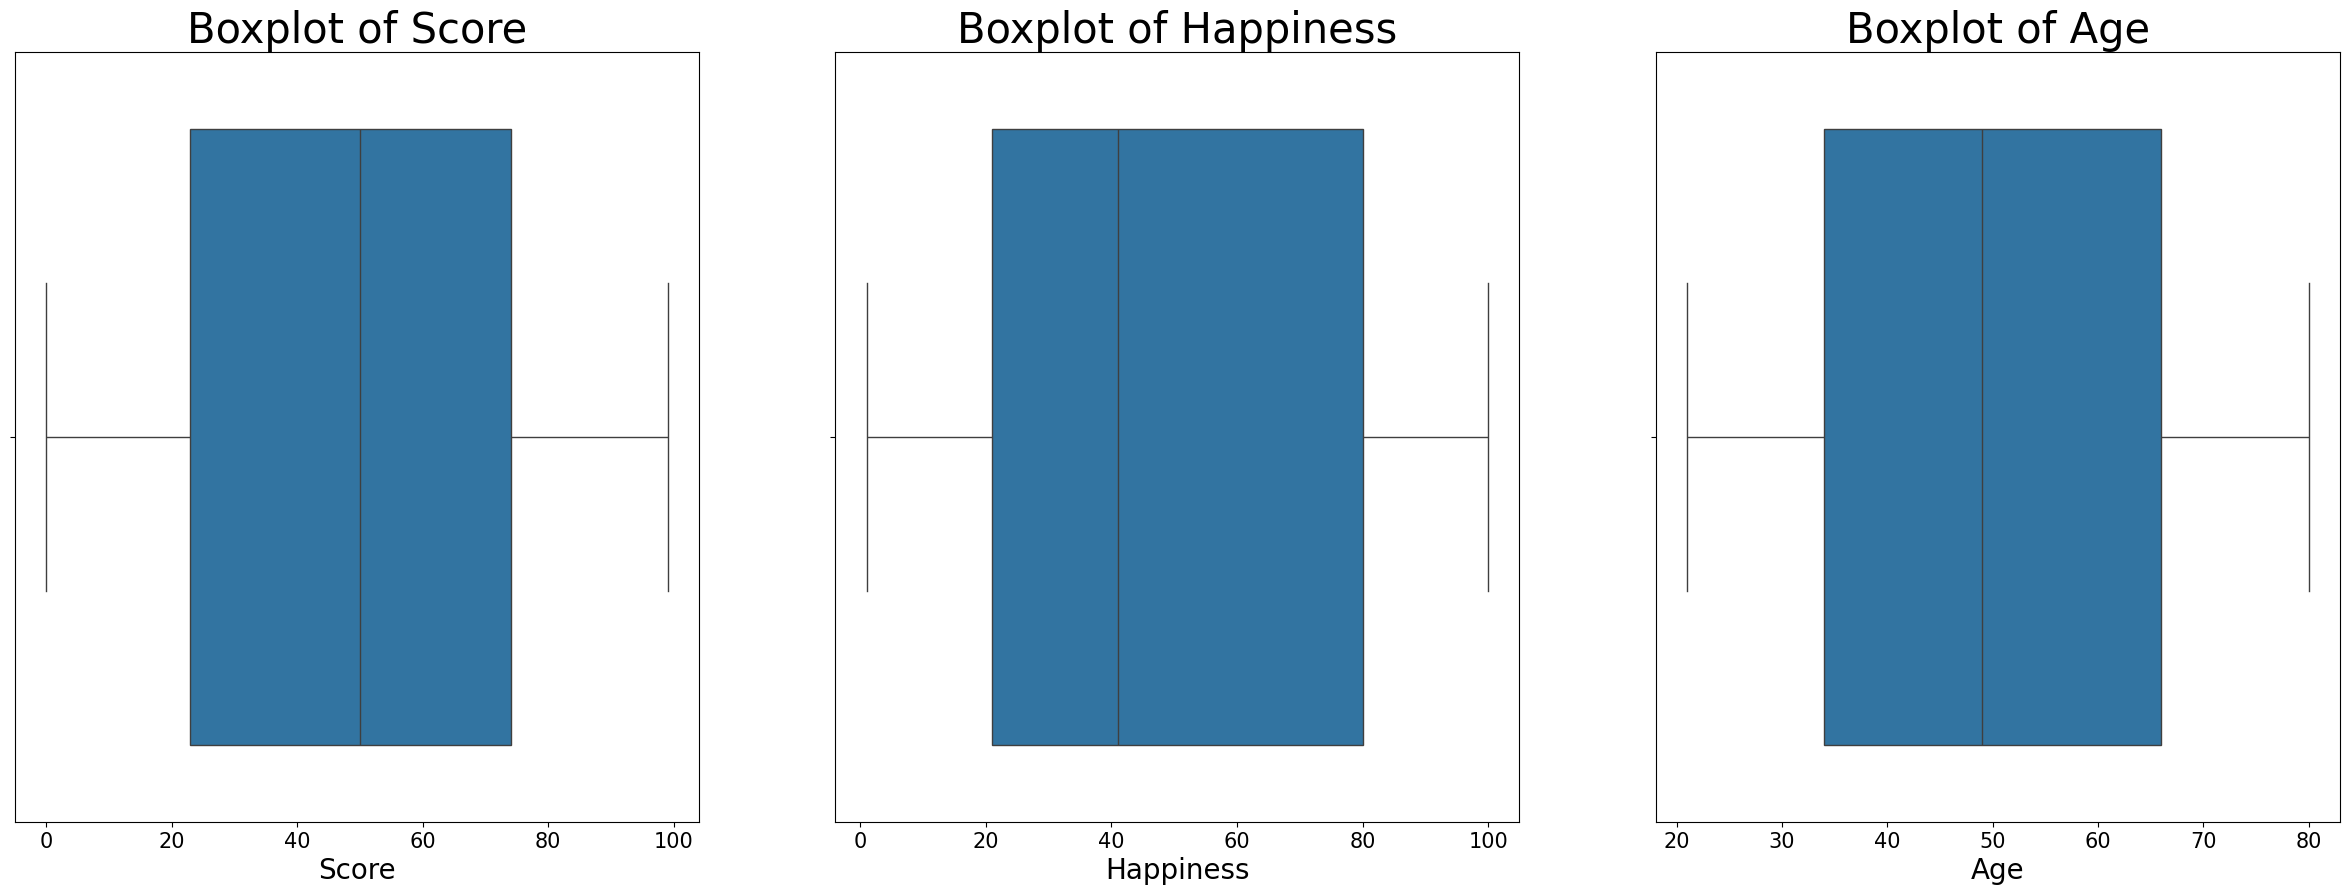

In [14]:
# Create boxplots for feature `score`, `happiness` and `Age`
plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
sns.boxplot(data=base_df, x='score')
plt.title('Boxplot of Score', fontsize=30)
plt.xlabel('Score', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(1, 3, 2)
sns.boxplot(data=base_df, x='happiness')
plt.title('Boxplot of Happiness', fontsize=30)
plt.xlabel('Happiness', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(1, 3, 3)
sns.boxplot(data=base_df, x='Age')
plt.title('Boxplot of Age', fontsize=30)
plt.xlabel('Age', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()